# Image Classification: Data Visualization and Model Exploration

## Introduction

This notebook demonstrates the importance of effective data visualization and exploratory data analysis (EDA) in image classification problems. We'll walk through a systematic approach to understanding image data before applying machine learning models.


### What are some reasons to care about data visualization?

### Answer:



*   Reduction in effort to understand results
*   Spatial relationships and color to differentiate data



## 1. Setting Up the Environment

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import warnings

# Set up plotting aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("viridis")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

## 2. Loading the Dataset

Load the dataset of Metal Defects of different Depths by Eddy Current Testing (MDDECT)
Data set has dimension (N,8,2,5,20,1250,2)
These represent number of experiments, scanning angles, foreword/backward movements, repeats, classes, temporal points, and channels)
The order of classes is 2.0 mm, 1.9 mm, 1.8 mm, …, 0.4 mm, 0.3 mm, lift-off and normal.

In [40]:
# Load the Fashion MDDECT dataset
test = np.load('MDDECT_v1_test.npy')
train = np.load('MDDECT_v1_train.npy')

# Define class names
class_names = ["2.0", "1.9","1.8","1.7","1.6","1.5","1.4","1.3","1.2","1.1","1.0","0.9","0.8","0.7","0.6","0.5","0.4","0.3","Lift-Off","Normal"]

# Original shape

print(test.shape)

# Get the first 5 dims (3, 8, 2, 5, 20)
idx = np.indices(test.shape[:5])  # Shape: (5, 3, 8, 2, 5, 20)
# Reshape each index into (4800,)
flat_indices = [dim.flatten() for dim in idx]  # List of 5 arrays of shape (4800,)

# Stack to get shape (4800, 5), where each row is the original indices (i,j,k,l,m)
test_index_map = np.stack(flat_indices, axis=1)

# Reshape the data to (4800, 1250, 2)
x_test = test.reshape(-1, 1250, 2)
y_test = test_index_map[:, 4]  # Shape: (4800,)
# Get the first 5 dims (3, 8, 2, 5, 20)
idx = np.indices(train.shape[:5])  # Shape: (5, 3, 8, 2, 5, 20)
# Reshape each index into (4800,)
flat_indices = [dim.flatten() for dim in idx]  # List of 5 arrays of shape (4800,)

# Stack to get shape (4800, 5), where each row is the original indices (i,j,k,l,m)
train_index_map = np.stack(flat_indices, axis=1)

# Reshape the data to (4800, 1250, 2)
x_train = train.reshape(-1, 1250, 2)
y_train = train_index_map[:, 4]  # Shape: (4800,)

#Display basic dataset information
print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

print(class_names[y_train[1]])

(3, 8, 2, 5, 20, 1250, 2)
Training images shape: (43200, 1250, 2)
Training labels shape: (43200,)
Test images shape: (4800, 1250, 2)
Test labels shape: (4800,)
Number of classes: 20
Class names: ['2.0', '1.9', '1.8', '1.7', '1.6', '1.5', '1.4', '1.3', '1.2', '1.1', '1.0', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', 'Lift-Off', 'Normal']
1.9


### Once you load a dataset, what is the most important next step?

### Answer : Sanity Checks

## 3. Exploratory Data Analysis (EDA)

### Visualizing Sample Images

Let's start by visualizing sample images from different classes.

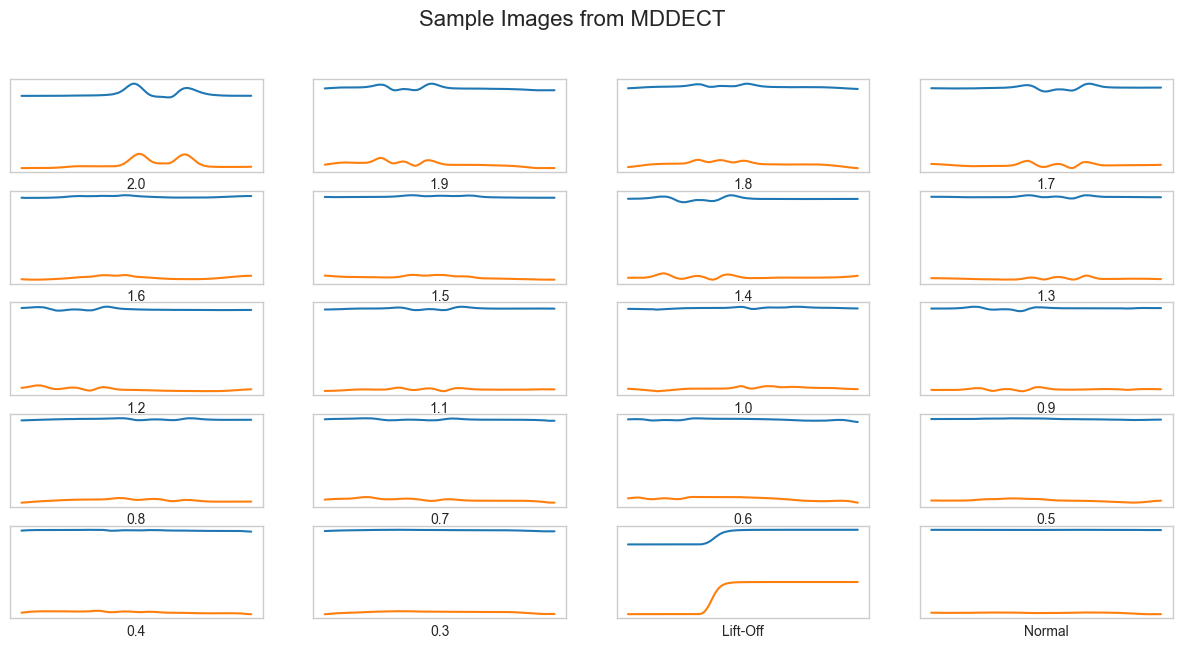

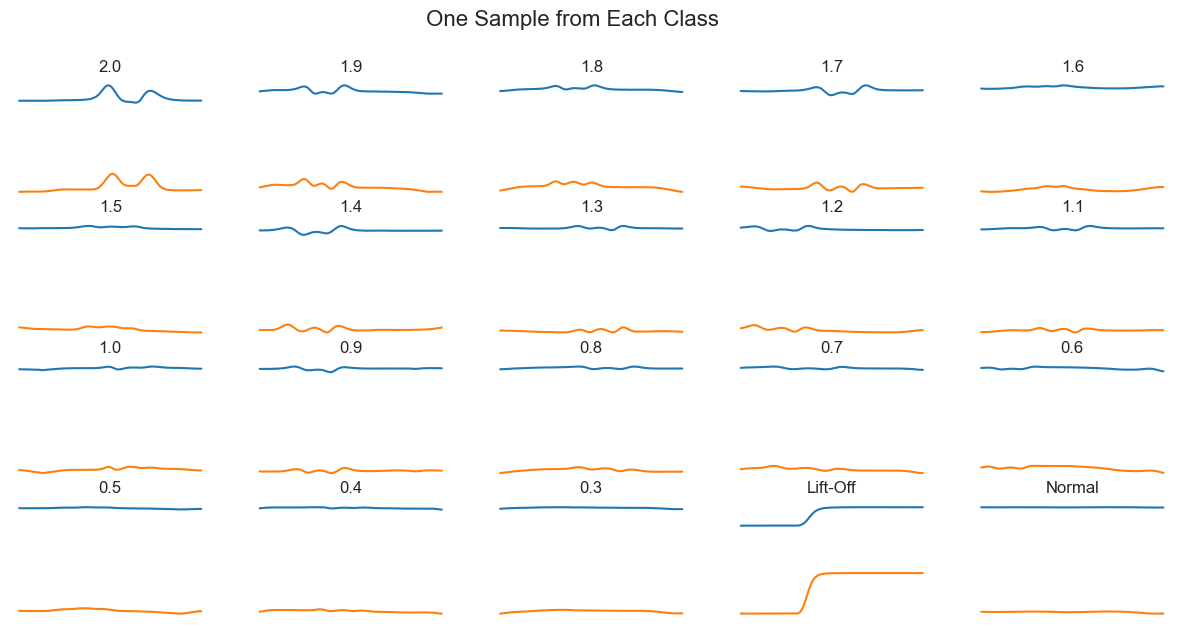

In [46]:
# Display a grid of sample images
plt.figure(figsize=(15, 7))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.plot(x_train[i])
    plt.xlabel(class_names[y_train[i]])
plt.suptitle('Sample Images from MDDECT', fontsize=16)
plt.show()

# Display one sample from each class
plt.figure(figsize=(15, 7))
for i in range(20):
    # Find the first image of each class
    idx = np.where(y_train == i)[0][0]
    plt.subplot(4, 5, i+1)
    plt.plot(x_train[idx])
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('One Sample from Each Class', fontsize=16)
plt.show()

### 3.2 Exploring Class Distribution

Let's check if our dataset is balanced across classes.

In [ ]:
# Analyze class distribution
def plot_class_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'Class': [class_names[i] for i in unique],
        'Count': counts
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', data=df, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Print statistics
    print(f"Total samples: {sum(counts)}")
    print(f"Minimum class size: {min(counts)} ({class_names[np.argmin(counts)]})")
    print(f"Maximum class size: {max(counts)} ({class_names[np.argmax(counts)]})")
    print(f"Class imbalance ratio (max/min): {max(counts)/min(counts):.2f}")

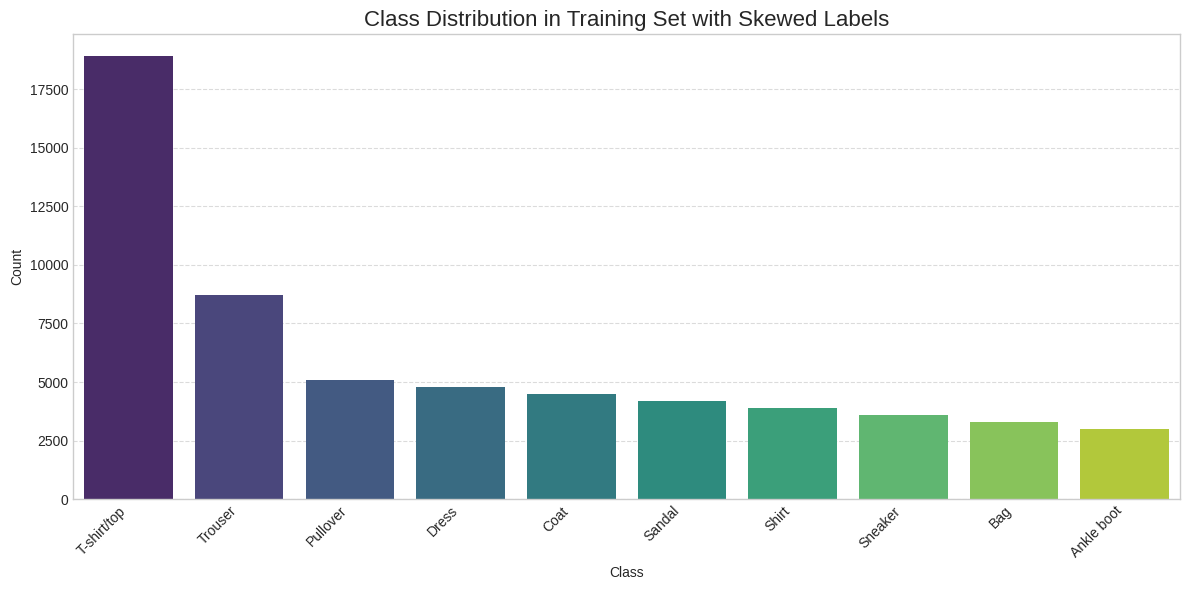

Total samples: 60000
Minimum class size: 3000 (Ankle boot)
Maximum class size: 18900 (T-shirt/top)
Class imbalance ratio (max/min): 6.30


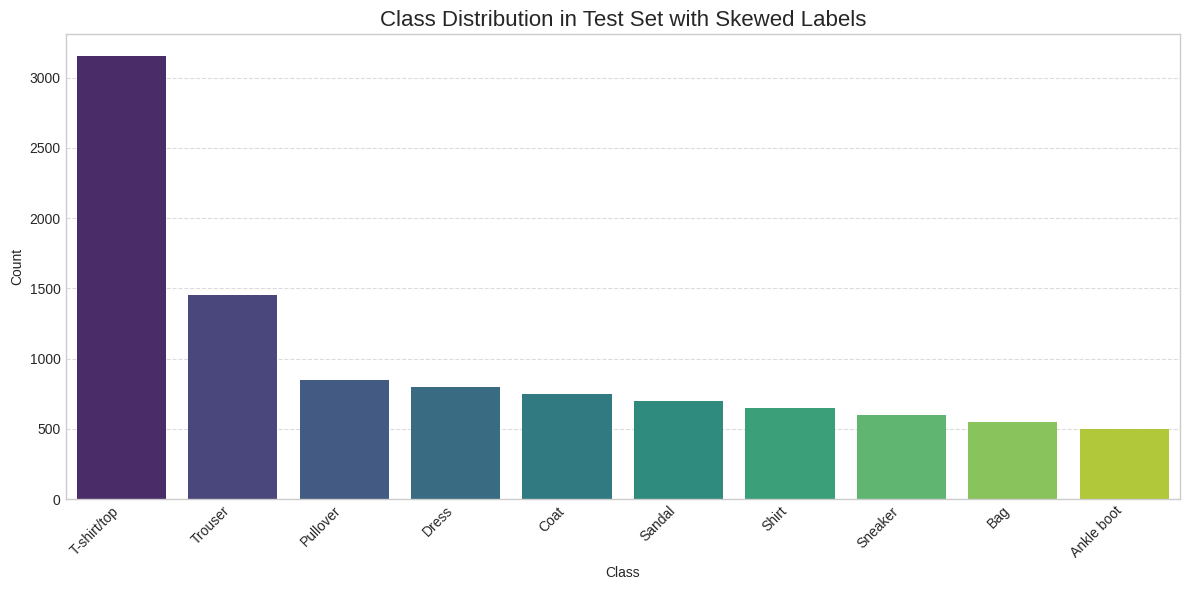

Total samples: 10000
Minimum class size: 500 (Ankle boot)
Maximum class size: 3150 (T-shirt/top)
Class imbalance ratio (max/min): 6.30


In [18]:
# Create copies of the training and test sets
y_train_incorrect = y_train.copy()
y_test_incorrect = y_test.copy()

# Define the replacement rules
# Format: {original_label: (new_label, replacement_percentage)}
replacement_rules = {
    9: (0, 0.5),   # Replace 50% of 9s with 0s
    8: (1, 0.45),  # Replace 45% of 8s with 1s
    7: (0, 0.4),   # Replace 40% of 7s with 0s
    6: (0, 0.35),  # Replace 35% of 6s with 0s
    5: (0, 0.3),   # Replace 30% of 5s with 0s
    4: (0, 0.25),  # Replace 25% of 4s with 0s
    3: (0, 0.2),   # Replace 20% of 3s with 0s
    2: (0, 0.15)   # Replace 15% of 2s with 0s
    # Keep 1s and 0s unchanged
}

# Apply replacements to training set
for original_label, (new_label, percentage) in replacement_rules.items():
    # Find indices where labels match the original label
    indices = np.where(y_train == original_label)[0]

    # Calculate how many labels to replace
    num_to_replace = int(len(indices) * percentage)

    # Randomly select indices to replace
    if num_to_replace > 0:
        replace_indices = np.random.choice(indices, size=num_to_replace, replace=False)

        # Replace selected indices with new label
        y_train_incorrect[replace_indices] = new_label

# Apply the same replacements to test set
for original_label, (new_label, percentage) in replacement_rules.items():
    indices = np.where(y_test == original_label)[0]
    num_to_replace = int(len(indices) * percentage)

    if num_to_replace > 0:
        replace_indices = np.random.choice(indices, size=num_to_replace, replace=False)
        y_test_incorrect[replace_indices] = new_label

# Plot class distribution for training and test sets
plot_class_distribution(y_train_incorrect, "Class Distribution in Training Set with Skewed Labels")
plot_class_distribution(y_test_incorrect, "Class Distribution in Test Set with Skewed Labels")


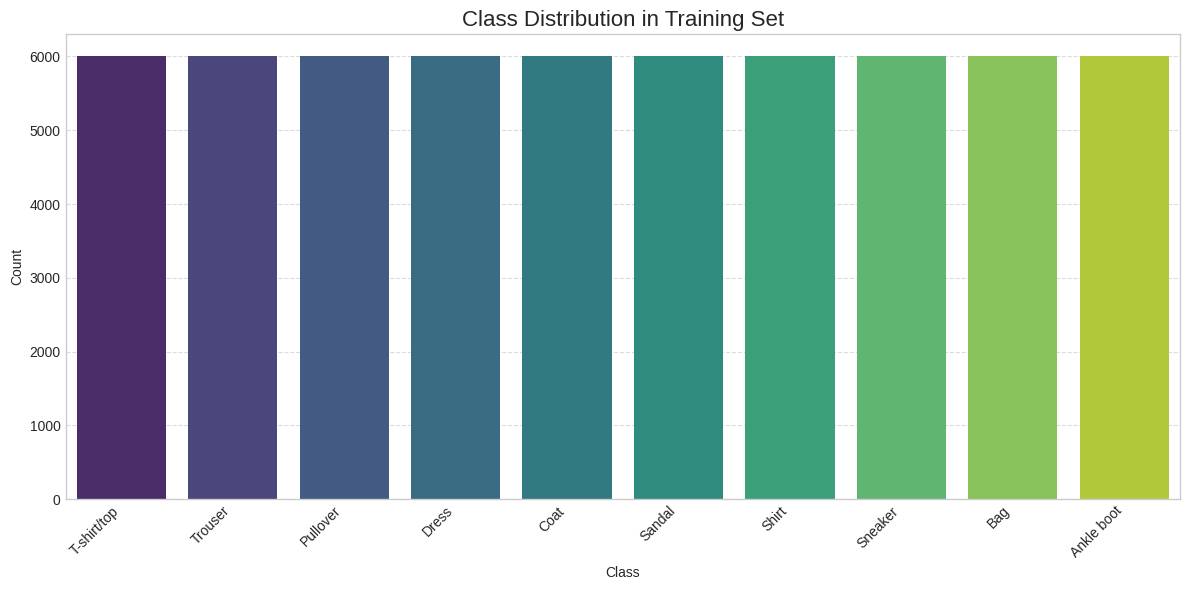

Total samples: 60000
Minimum class size: 6000 (T-shirt/top)
Maximum class size: 6000 (T-shirt/top)
Class imbalance ratio (max/min): 1.00


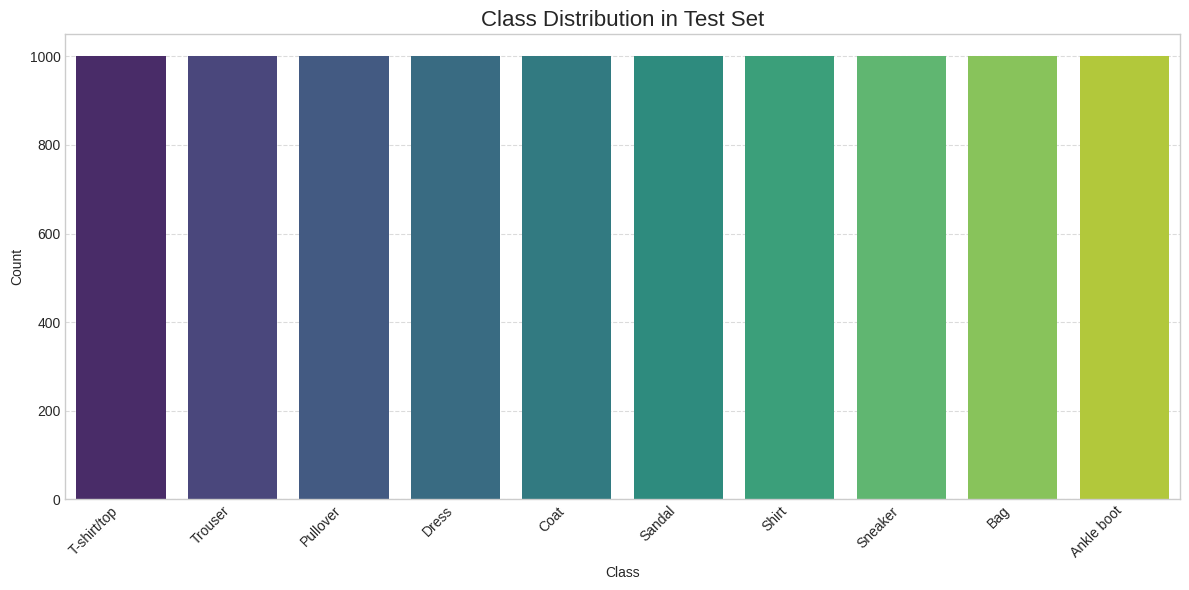

Total samples: 10000
Minimum class size: 1000 (T-shirt/top)
Maximum class size: 1000 (T-shirt/top)
Class imbalance ratio (max/min): 1.00


In [19]:
# Plot class distribution for training and test sets
plot_class_distribution(y_train, "Class Distribution in Training Set")
plot_class_distribution(y_test, "Class Distribution in Test Set")

### Once you have completed sanity checks, what's the next step?

### Answer : Plot Average and Standard Deviation of the inputs

### Image Intensity Analysis

Let's analyze the pixel intensity distributions across different classes.

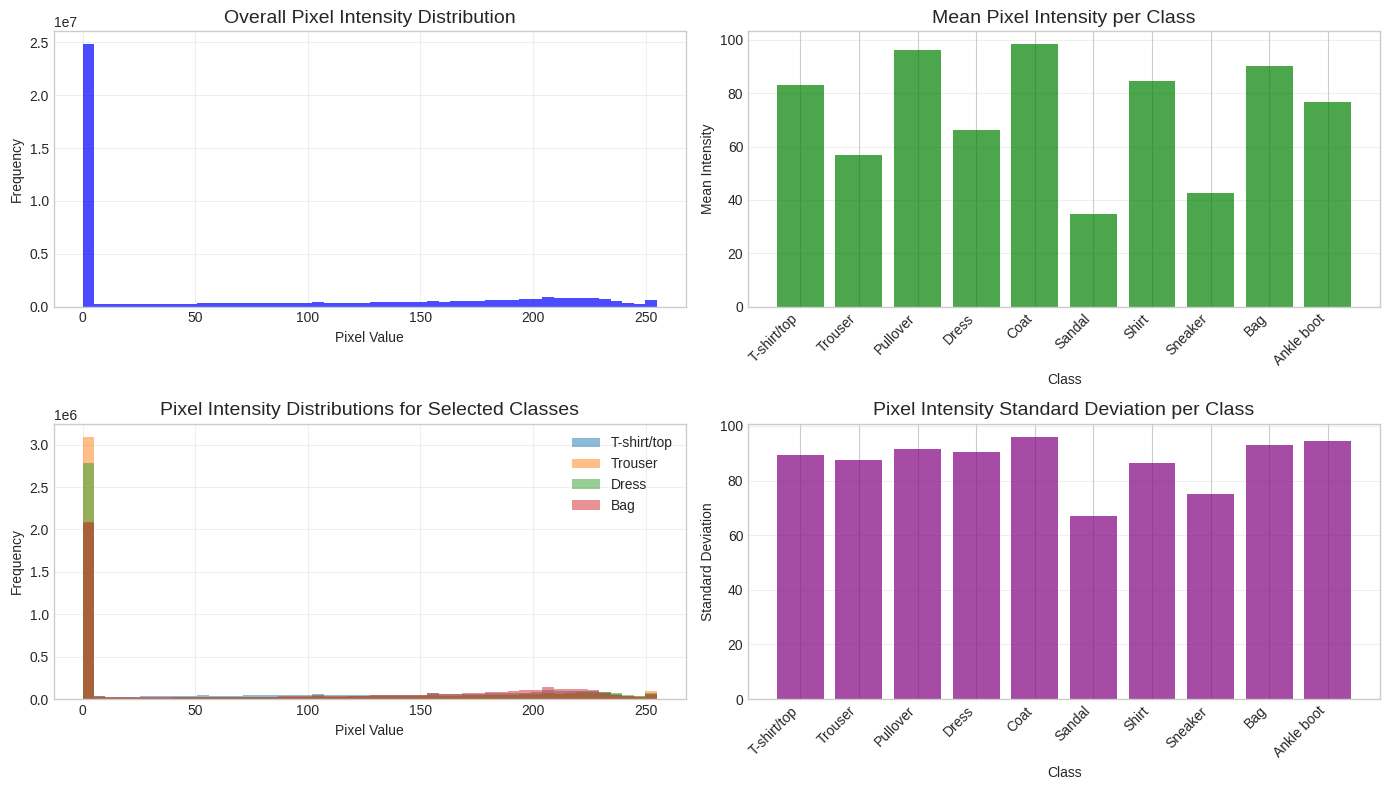

In [20]:
# Analyze pixel intensity distributions
plt.figure(figsize=(14, 8))

# Overall pixel intensity distribution
plt.subplot(2, 2, 1)
plt.hist(x_train.reshape(-1), bins=50, alpha=0.7, color='blue')
plt.title('Overall Pixel Intensity Distribution', fontsize=14)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

# Mean pixel intensity per class
class_means = [x_train[y_train == i].mean() for i in range(10)]
plt.subplot(2, 2, 2)
bars = plt.bar(range(10), class_means, color='green', alpha=0.7)
plt.xticks(range(10), class_names, rotation=45, ha='right')
plt.title('Mean Pixel Intensity per Class', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Mean Intensity')
plt.grid(axis='y', alpha=0.3)

# Pixel intensity distributions for selected classes
plt.subplot(2, 2, 3)
selected_classes = [0, 1, 3, 8]  # T-shirt, Trouser, Dress, Bag
for i in selected_classes:
    plt.hist(x_train[y_train == i].reshape(-1), bins=50, alpha=0.5, label=class_names[i])
plt.title('Pixel Intensity Distributions for Selected Classes', fontsize=14)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)

# Plot pixel intensity standard deviation per class
class_stds = [x_train[y_train == i].std() for i in range(10)]
plt.subplot(2, 2, 4)
plt.bar(range(10), class_stds, color='purple', alpha=0.7)
plt.xticks(range(10), class_names, rotation=45, ha='right')
plt.title('Pixel Intensity Standard Deviation per Class', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Standard Deviation')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Visualizing Class Differences through Average Images

Let's create and visualize average images for each class to understand class characteristics.

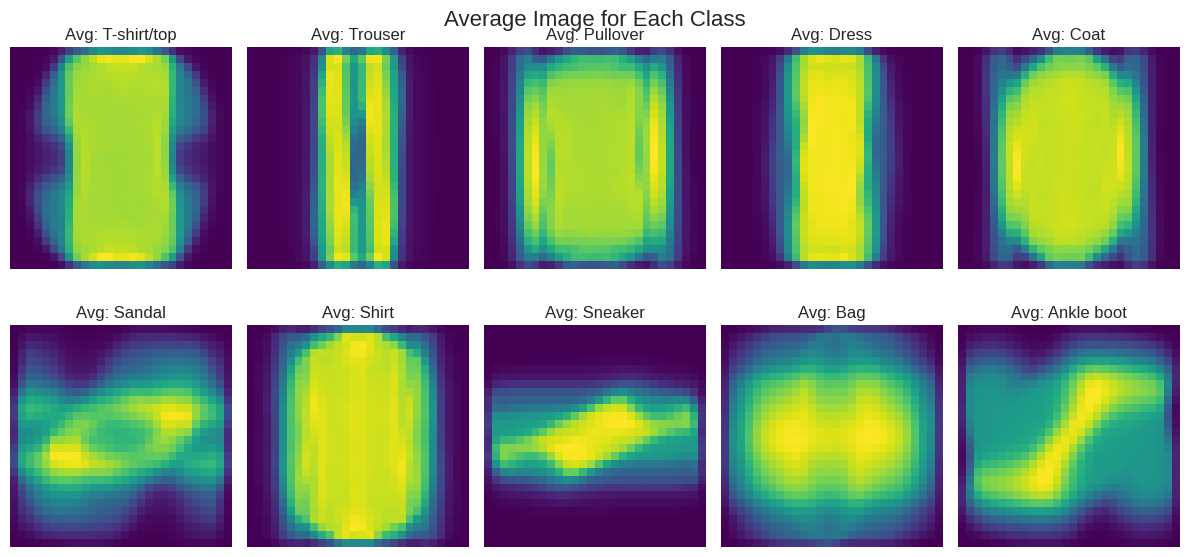

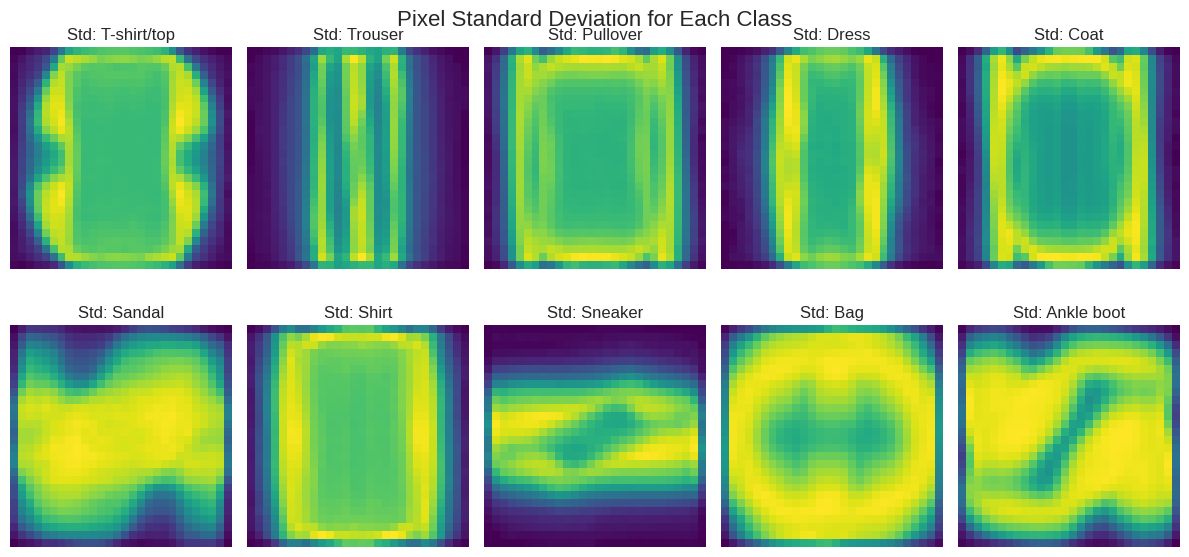

In [21]:
# Rotate every alternate image in x_train by 180 degrees
x_train_rotated = x_train.copy()
for i in range(0, len(x_train), 2):
    x_train_rotated[i] = np.rot90(x_train[i], 2)  # Rotate by 180 degrees

# Compute and display average images for each class
plt.figure(figsize=(12, 6))
for i in range(10):
    # Compute average image for class i
    avg_image = np.mean(x_train_rotated[y_train == i], axis=0)

    # Display average image
    plt.subplot(2, 5, i+1)
    plt.imshow(avg_image, cmap='viridis')
    plt.title(f'Avg: {class_names[i]}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Average Image for Each Class', y=0.98, fontsize=16)
plt.show()

# Calculate and visualize standard deviation images
plt.figure(figsize=(12, 6))
for i in range(10):
    # Compute standard deviation image for class i
    std_image = np.std(x_train_rotated[y_train == i], axis=0)

    # Display standard deviation image
    plt.subplot(2, 5, i+1)
    plt.imshow(std_image, cmap='viridis')
    plt.title(f'Std: {class_names[i]}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Pixel Standard Deviation for Each Class', y=0.98, fontsize=16)
plt.show()

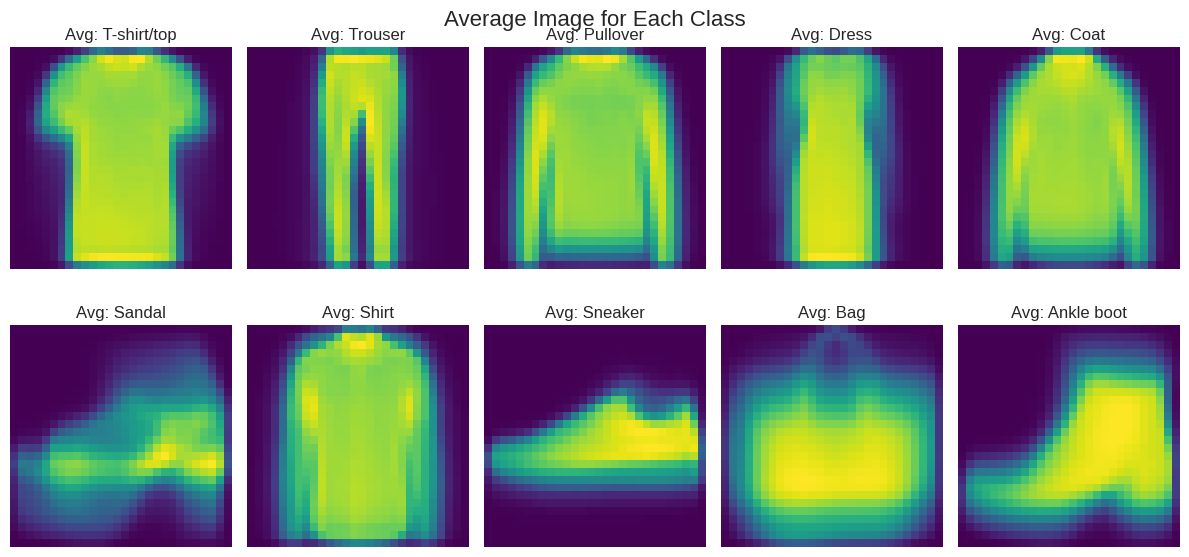

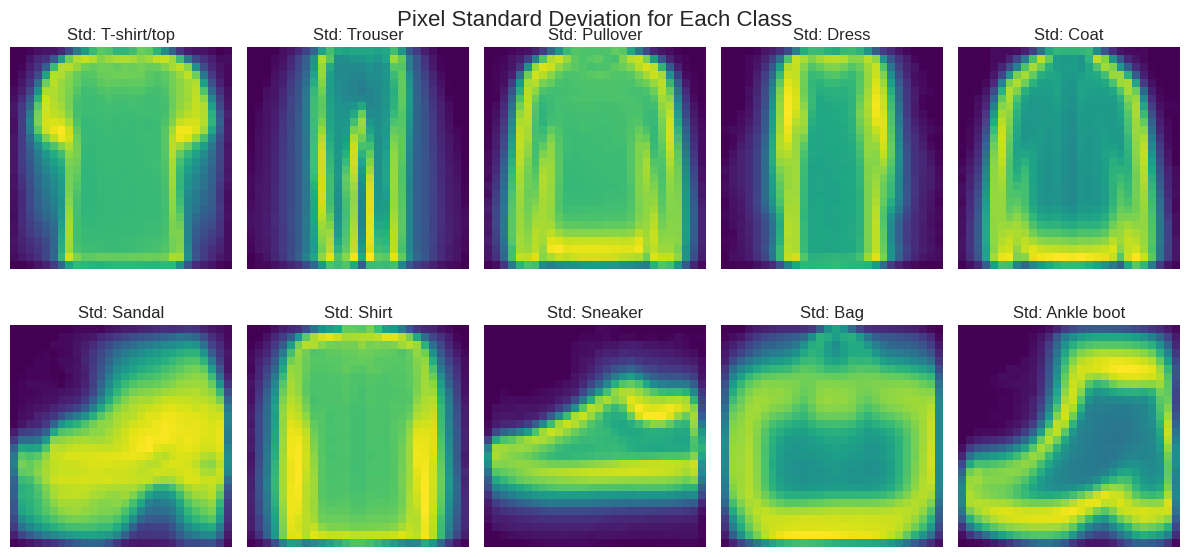

In [22]:
# Compute and display average images for each class
plt.figure(figsize=(12, 6))
for i in range(10):
    # Compute average image for class i
    avg_image = np.mean(x_train[y_train == i], axis=0)

    # Display average image
    plt.subplot(2, 5, i+1)
    plt.imshow(avg_image, cmap='viridis')
    plt.title(f'Avg: {class_names[i]}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Average Image for Each Class', y=0.98, fontsize=16)
plt.show()

# Calculate and visualize standard deviation images
plt.figure(figsize=(12, 6))
for i in range(10):
    # Compute standard deviation image for class i
    std_image = np.std(x_train[y_train == i], axis=0)

    # Display standard deviation image
    plt.subplot(2, 5, i+1)
    plt.imshow(std_image, cmap='viridis')
    plt.title(f'Std: {class_names[i]}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Pixel Standard Deviation for Each Class', y=0.98, fontsize=16)
plt.show()

### When making plots, how should you pick colors for your plots?



### t-SNE Visualization for Class Separation

t-SNE is a dimensionality reduction technique that can help visualize high-dimensional data. Let's use it to see if our classes are naturally separable.

In [23]:
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [24]:
# Use t-SNE to visualize class separation
from sklearn.manifold import TSNE

# Sample a subset of images for t-SNE (for computational efficiency)
n_samples = 2000
sample_indices = np.random.choice(len(x_train), size=n_samples, replace=False)
sample_images = x_train[sample_indices].reshape(n_samples, -1)  # Flatten images
sample_labels = y_train[sample_indices]

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(sample_images)
print("t-SNE completed.")

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1],
    'label': [class_names[label] for label in sample_labels]
})



Applying t-SNE...
t-SNE completed.


### Bad

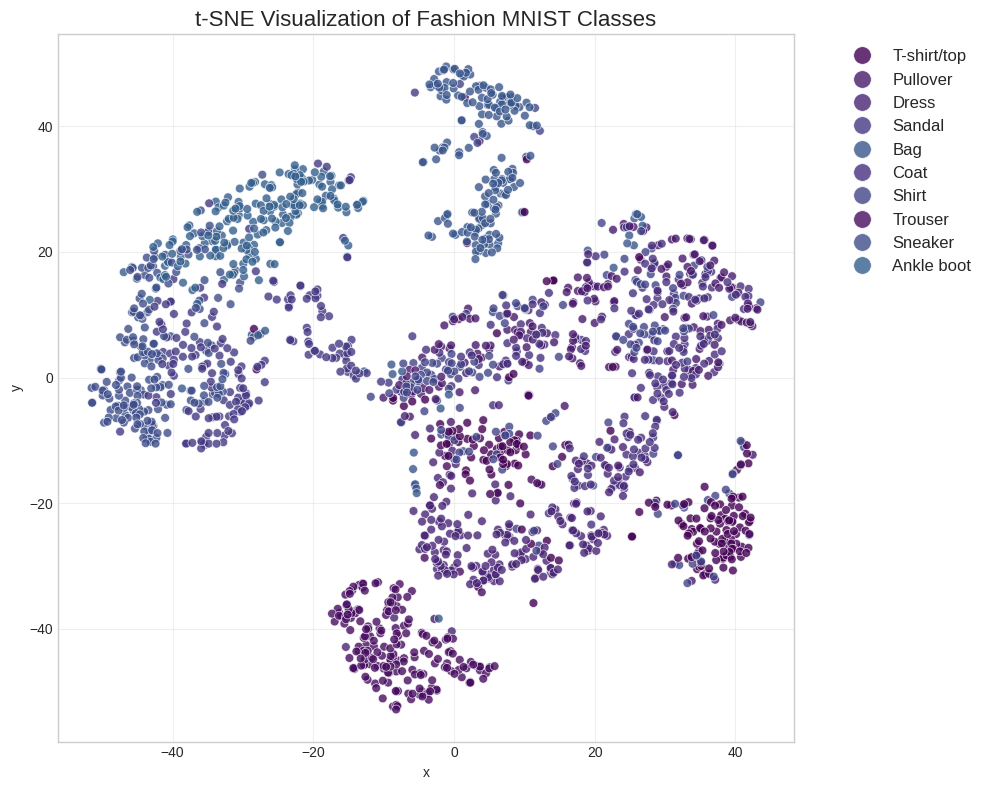

In [25]:
# Use the viridis colormap
from matplotlib.cm import viridis

# Create a discrete colormap with 10 colors (one for each class)
n_colors = len(class_names)
viridis_colors = viridis(np.linspace(0, 0.3, n_colors))

# Create a custom palette dictionary mapping each class to a color
custom_palette = {class_name: viridis_colors[i] for i, class_name in enumerate(class_names)}

# Plot t-SNE results with the custom palette
plt.figure(figsize=(10, 8))  # Larger figure to accommodate the bigger legend
sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, palette=custom_palette, alpha=0.8, s=40)
plt.title('t-SNE Visualization of Fashion MNIST Classes', fontsize=16)

# Create a bigger legend with larger font size and marker size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=2)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Good

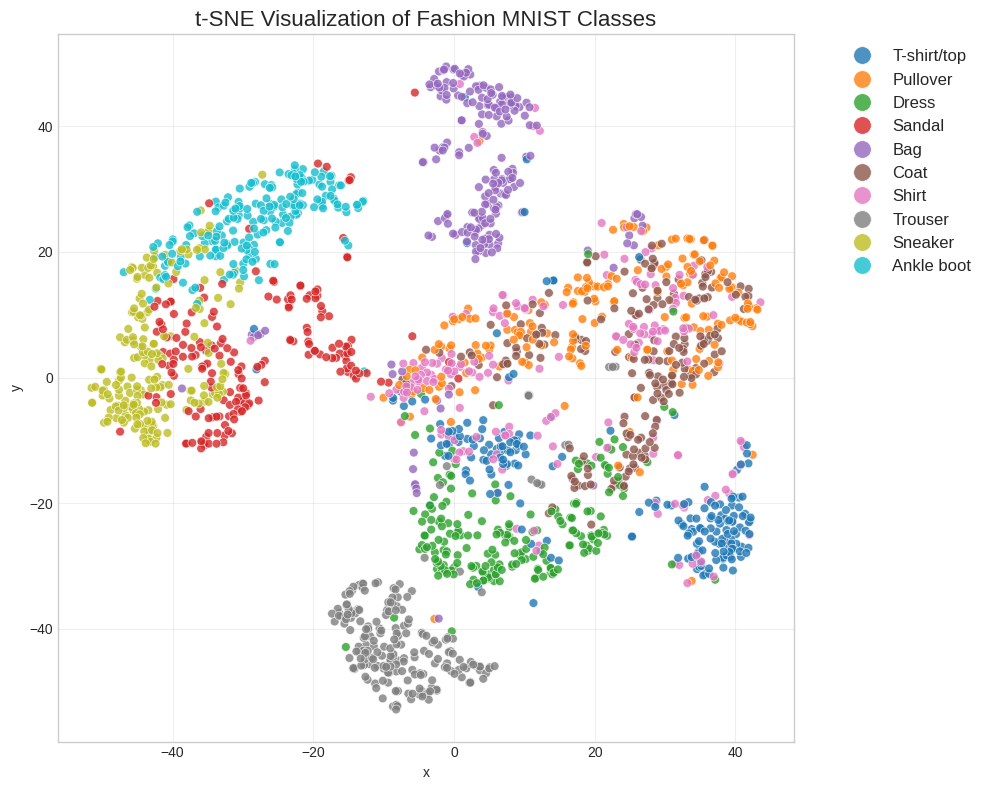

In [26]:
# Plot t-SNE results'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, alpha=0.8, s=40)
plt.title('t-SNE Visualization of Fashion MNIST Classes', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Better

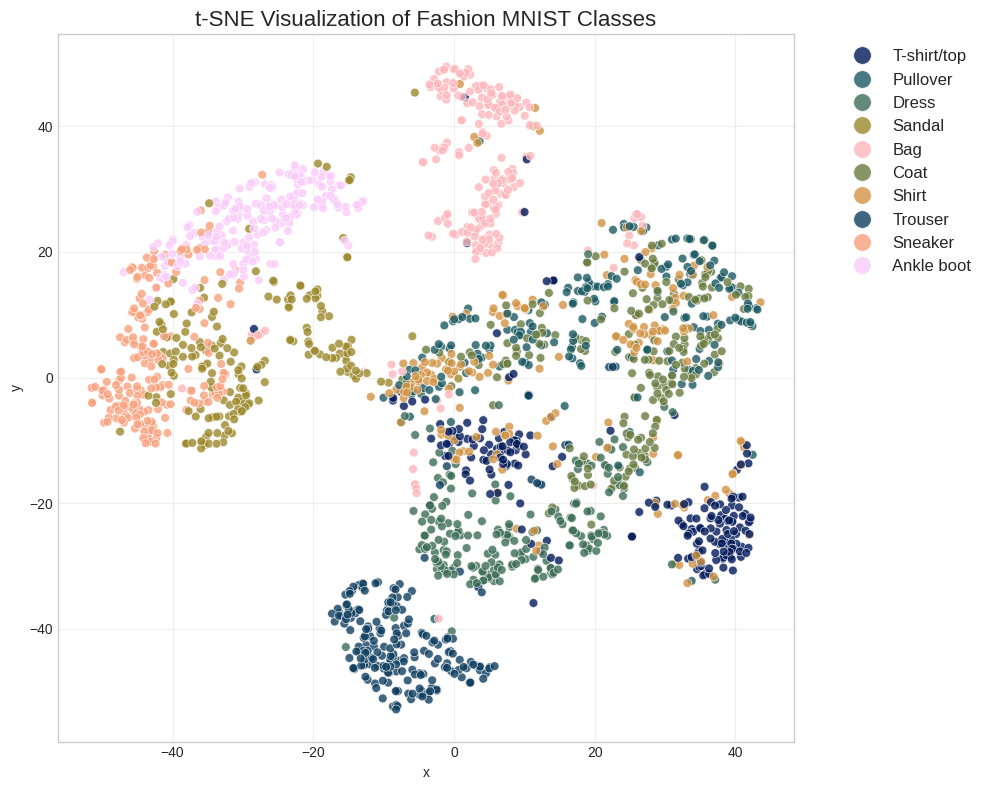

In [27]:
# First, let's install the Scientific Colour Maps package if not already installed
try:
    import cmcrameri.cm as cmc
except ImportError:
    !pip install cmcrameri
    import cmcrameri.cm as cmc

# Define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Use a categorical colormap - create a discrete version of batlow
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Create a discrete colormap with 10 colors (one for each class)
n_colors = len(class_names)
batlow_colors = cmc.batlow(np.linspace(0, 1, n_colors))
batlow10 = ListedColormap(batlow_colors)

# Create a custom palette dictionary mapping each class to a color
custom_palette = {class_name: batlow_colors[i] for i, class_name in enumerate(class_names)}

# Plot t-SNE results with the custom palette
plt.figure(figsize=(10, 8))  # Made the figure larger to accommodate the bigger legend
sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, palette=custom_palette, alpha=0.8, s=40)
plt.title('t-SNE Visualization of Fashion MNIST Classes', fontsize=16)

# Create a bigger legend with larger font size and marker size
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, markerscale=2)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Image Preprocessing

In [28]:
# Normalize pixel values to be between 0 and 1
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

# Reshape for CNN input (add channel dimension)
x_train_reshaped = x_train_norm.reshape(x_train_norm.shape[0], 28, 28, 1)
x_test_reshaped = x_test_norm.reshape(x_test_norm.shape[0], 28, 28, 1)

# Convert labels to one-hot encoded format
y_train_onehot = to_categorical(y_train, 10)
y_test_onehot = to_categorical(y_test, 10)

# Create a validation set
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_reshaped, y_train_onehot, test_size=0.2, random_state=42
)

# Print shapes
print(f"Training images shape: {x_train_final.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Test images shape: {x_test_reshaped.shape}")
print(f"Training labels shape: {y_train_final.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test_onehot.shape}")
print(f"Pixel value range: {x_train_final.min()} to {x_train_final.max()}")

Training images shape: (48000, 28, 28, 1)
Validation images shape: (12000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)
Training labels shape: (48000, 10)
Validation labels shape: (12000, 10)
Test labels shape: (10000, 10)
Pixel value range: 0.0 to 1.0


## 5. Baseline Model Building and Evaluation

Let's start with simple models to establish a performance baseline.

In [29]:
# 5.1 Simple Fully Connected Neural Network
def build_simple_nn():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 5.2 Simple CNN
def build_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build models
simple_nn = build_simple_nn()
simple_cnn = build_simple_cnn()

# Print model summaries
print("Simple Neural Network Summary:")
simple_nn.summary()

print("\nSimple CNN Summary:")
simple_cnn.summary()

Simple Neural Network Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Simple CNN Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train Simple Neural Network
simple_nn_history = simple_nn.fit(
    x_train_final, y_train_final,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=1
)

# Train Simple CNN
simple_cnn_history = simple_cnn.fit(
    x_train_final, y_train_final,
    epochs=5,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7607 - loss: 0.7134 - val_accuracy: 0.8494 - val_loss: 0.4295
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8520 - loss: 0.4089 - val_accuracy: 0.8572 - val_loss: 0.4052
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8691 - loss: 0.3576 - val_accuracy: 0.8630 - val_loss: 0.3786
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8805 - loss: 0.3262 - val_accuracy: 0.8650 - val_loss: 0.3750
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8899 - loss: 0.3024 - val_accuracy: 0.8668 - val_loss: 0.3673
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.7357 - loss: 0.7472 - val_accuracy: 0.8559 - val_loss: 0.3947
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.8661 - loss: 0.3745 - val_accuracy: 0.8705 - val_loss: 0.3551
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.8862 - loss: 0.3198 - val_accuracy: 0.88

### 5.3 Visualizing Training Progress

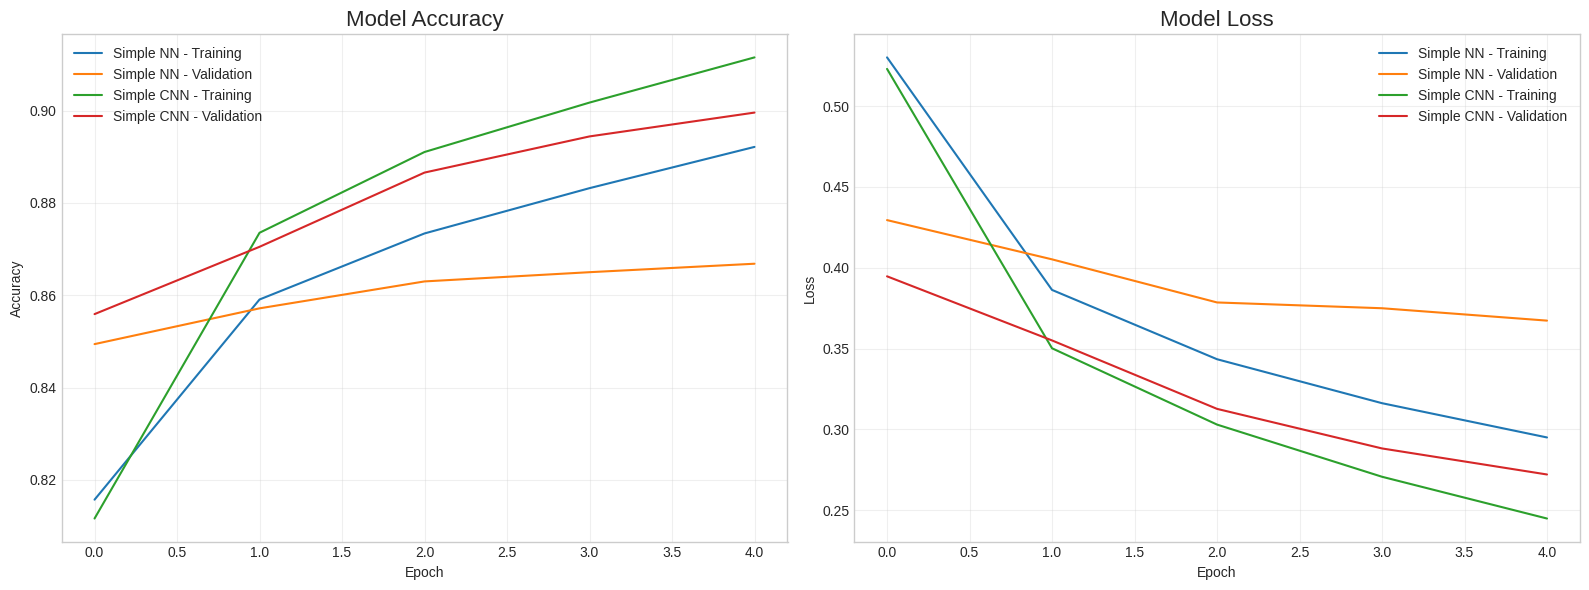

In [31]:
# Function to plot training history
def plot_training_history(histories, model_names):
    # Set up plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot accuracy
    for history, name in zip(histories, model_names):
        ax1.plot(history.history['accuracy'], label=f'{name} - Training')
        ax1.plot(history.history['val_accuracy'], label=f'{name} - Validation')

    ax1.set_title('Model Accuracy', fontsize=16)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot loss
    for history, name in zip(histories, model_names):
        ax2.plot(history.history['loss'], label=f'{name} - Training')
        ax2.plot(history.history['val_loss'], label=f'{name} - Validation')

    ax2.set_title('Model Loss', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(
    [simple_nn_history, simple_cnn_history],
    ['Simple NN', 'Simple CNN']
)